In [3]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [35]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [62]:
def label(model, device, data_loader):
    model.eval()
    preds = []
    with torch.no_grad():
        for data in data_loader:
            data = data[0].to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=False)
            preds.append(pred.cpu().numpy())
    return np.concatenate(preds)

In [7]:
def manual_transform(data, mean, std):
    if torch.is_tensor(data):
        data = data.numpy()
    
    data = (data - mean) / std        

    data = np.transpose(data, [0, 3, 1, 2])
        
    return data

In [30]:
def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1], 3))
    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w, :] = image

    return img

## MNIST

In [8]:
class MNIST_net(nn.Module):
    def __init__(self):
        super(MNIST_net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [9]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

In [11]:
mnist_samples = np.load('data/mnist_samples.npy')
transformed_samples = manual_transform(mnist_samples, (0.1307,), (0.3081,))

In [ ]:
mnist_tensor = torch.tensor(transformed_samples, dtype=torch.float32)
mnist_dataset = torch.utils.data.TensorDataset(mnist_tensor)
mnist_dataloader = torch.utils.data.DataLoader(mnist_dataset, batch_size=1000, shuffle=False)

In [18]:
model = MNIST_net().to(device)
state_dict = torch.load('models/mnist_labeler.pt')
model.load_state_dict(state_dict)

In [23]:
mnist_labels = label(model, device, mnist_dataloader)

In [25]:
mnist_labels.shape

(100000,)

In [93]:
# Separate samples according to label
samples_by_labels = [[] for _ in range(10)]
for i in range(len(mnist_samples)):
    samples_by_labels[mnist_labels[i]].append(mnist_samples[i])

In [94]:
for i in range(10):
    samples_by_labels[i] = np.array(samples_by_labels[i])

In [95]:
merge(mnist_samples[:64], [8,8]).shape

(224, 224, 3)

In [96]:
label_to_display = 9

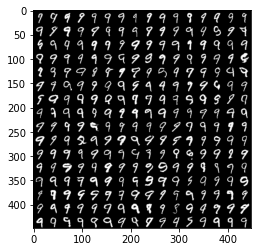

In [100]:
plt.imshow(merge(samples_by_labels[label_to_display][:64], [8,8]))

In [101]:
for i in range(10):
    print(len(samples_by_labels[i]))

9752
12133
9229
10320
9701
9439
9541
10724
9396
9765


In [102]:
np.save(open("mnist_samples_labels.npy", "wb"), mnist_labels)

## CIFAR

In [53]:
'''ResNet in PyTorch.

For Pre-activation ResNet, see 'preact_resnet.py'.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [54]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [55]:
cifar_samples = np.load('data/cifar_samples.npy')
transformed_samples = manual_transform(cifar_samples, (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

In [56]:
cifar_tensor = torch.tensor(transformed_samples, dtype=torch.float32)
cifar_dataset = torch.utils.data.TensorDataset(cifar_tensor)
cifar_dataloader = torch.utils.data.DataLoader(cifar_dataset, batch_size=1000, shuffle=False)

In [57]:
model = ResNet18().to(device)
state_dict = torch.load('models/cifar_labeler.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [65]:
cifar_labels = label(model, device, cifar_dataloader)

In [66]:
cifar_labels.shape

(100000,)

In [67]:
# Separate samples according to label
samples_by_labels = [[] for _ in range(10)]
for i in range(len(cifar_samples)):
    samples_by_labels[cifar_labels[i]].append(cifar_samples[i])

In [68]:
for i in range(10):
    samples_by_labels[i] = np.array(samples_by_labels[i])

In [69]:
merge(cifar_samples[:64], [8,8]).shape

(256, 256, 3)

In [89]:
label_to_display = 9

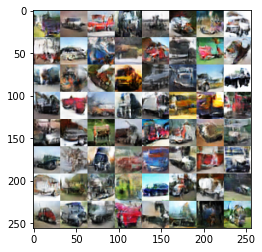

In [90]:
plt.imshow(merge(samples_by_labels[label_to_display][:64], [8,8]))

In [92]:
for i in range(10):
    print(len(samples_by_labels[i]))

12603
6109
5979
10193
11695
7682
13341
9746
13946
8706


In [ ]:
np.save(open("cifar_samples_labels.npy", "wb"), cifar_labels)